In [57]:
#   ___                  _                
#  / _/______ ____  ____(_)__ _______     
# / _/ __/ _ `/ _ \/ __/ (_-</ __/ _ \    
#/_//_/  \_,_/_//_/\__/_/___/\__/\___/    
# ___ _____(_)__ ___ ____  / /_(_)       
# / _ `/ __/ (_-</ _ `/ _ \/ __/ /        
# \_, /_/ /_/___/\_,_/_//_/\__/_/         
#/___/
#
#Samee Lab @ Baylor College Of Medicine
#francisco.grisanticanozo@bcm.edu

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import pprint
from pathlib import Path
import os
import sys
#from tqdm.notebook import trange, tqdm

#Plotting lib
from matplotlib import pyplot as plt
import seaborn as sb
%matplotlib inline
plt.style.use('ggplot')

#Specific lib
import scanpy as sc
import scanpy.external as sce
import anndata
import warnings
import logging

sc.settings.verbosity = 3
sc.logging.print_header()
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.set_figure_params(dpi=150)
plt.rcParams['figure.figsize']=(8,8) #rescale figures

plt.rcParams['pdf.fonttype'] = 42
plt.rc('font',**{'family':'serif','serif':['Arial']})

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1


# Merfish

## Read raw data

In [ ]:
data = pd.read_csv('../Data/Merfish/Moffitt_and_Bambah-Mukku_et_al_merfish_all_cells.csv')
data = data.set_index('Cell_ID')

#Get obs from data
obs = data[['Animal_ID',
            'Animal_sex',
            'Behavior',
            'Bregma',
            'Centroid_X',
            'Centroid_Y',
            'Cell_class',
            'Neuron_cluster_ID']]

#Get counts from data
counts = data.copy()
counts = counts.drop(['Animal_ID',
            'Animal_sex',
            'Behavior',
            'Bregma',
            'Centroid_X',
            'Centroid_Y',
            'Cell_class',
            'Neuron_cluster_ID'],axis=1)

#build adata object
adata = anndata.AnnData(counts)
adata.obs = obs

#set spatial coordinates
adata.obs['pixel_x'] = adata.obs['Centroid_X']
adata.obs['pixel_y'] = adata.obs['Centroid_Y']
adata.obsm["spatial"] = adata.obs[['pixel_x','pixel_y']].to_numpy()


#fill NaN values with 0 counts
adata_df = adata.to_df().fillna(0)
adata.X = adata_df.to_numpy()

#Basic normalization/scaling
#sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.scale(adata)

In [ ]:
adata.write('../Data/Merfish/merfish_raw.h5ad')

In [24]:
adata = sc.read('../Data/Merfish/merfish_raw.h5ad')

In [25]:
adata.obs['Cell_class'].value_counts()

Inhibitory       324178
Ambiguous        153080
Excitatory       143846
Astrocyte        108560
OD Mature 2       85278
Endothelial 1     50320
OD Immature 1     32043
OD Mature 1       28681
Endothelial 3     21390
Microglia         21165
Ependymal         20473
Endothelial 2     13392
Pericytes          9995
OD Mature 4        9511
OD Mature 3        3256
OD Immature 2      2680
Name: Cell_class, dtype: int64

In [26]:
adata.obs['celltype'] = adata.obs['Cell_class'].astype(str)
for index,row in adata.obs.iterrows():
    if row['Cell_class'] in ['Inhibitory']:
        adata.obs.at[index,'celltype'] = 'Inhibitory'
    elif row['Cell_class'] in ['Excitatory']:
        adata.obs.at[index,'celltype'] = 'Excitatory'
    elif row['Cell_class'] in ['OD Mature 1','OD Mature 2','OD Mature 3','OD Mature 4']:
        adata.obs.at[index,'celltype'] = 'Mature oligodendrocyte'    
    elif row['Cell_class'] in ['OD Immature 1','OD Immature 2']:
        adata.obs.at[index,'celltype'] = 'Immature oligodendrocyte'
    elif row['Cell_class'] in ['Endothelial 1','Endothelial 2','Endothelial 3']:
        adata.obs.at[index,'celltype'] = 'Endothelial'
    elif row['Cell_class'] in ['Astrocyte']:
        adata.obs.at[index,'celltype'] = 'Astrocytes'

In [27]:
adata.obs['celltype'].value_counts()

Inhibitory                  324178
Ambiguous                   153080
Excitatory                  143846
Mature oligodendrocyte      126726
Astrocytes                  108560
Endothelial                  85102
Immature oligodendrocyte     34723
Microglia                    21165
Ependymal                    20473
Pericytes                     9995
Name: celltype, dtype: int64

In [34]:
adata = adata[~adata.obs['celltype'].isin(['Ambiguous','Pericytes']),:]

In [35]:
adata.write('../Data/Merfish/merfish_processed.h5ad')

/home/franciscog/.conda/envs/STANN/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical


In [ ]:
test = adata[adata.obs['Animal_ID'].isin([8]),:]

sc.settings.set_figure_params(dpi=200)
sc.pl.spatial(test,
              color=None,
              #vmin=0, vmax=0.2,
              #color_map=plt.cm.YlOrRd,
              spot_size=20,
              title= ["Merfish Animal ID 8"],
              #legend='None',
              save='_Merfish Animal ID 8_'
              )

In [ ]:
test = adata[adata.obs['Animal_ID'].isin([8]),:]
test.obs['Bregma'] = test.obs['Bregma'].astype(str)

i=0
for section in test.obs['Bregma'].unique():
    test_temp = test[test.obs['Bregma'].isin([section]),:]
    test_temp.write(f'../Data/Merfish/merfish_AID8_Section_{i}.h5ad')
    i=i+1

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.spatial(test_temp,
              color=["celltype"],
              #vmin=0, vmax=0.2,
              #color_map=plt.cm.YlOrRd,
              spot_size=20,
              title= ["Bregma"],
              #save='Yap_Score_P2R1_v2'
              )

# Single-cell

In [ ]:
adata = sc.read_10x_mtx('../Data/Single_Cell_Reference/',cache=True)

In [ ]:
obs = pd.read_csv('../Data/Single_Cell_Reference/aau5324_Moffitt_Table-S1.csv',index_col='Cell name')

In [ ]:
adata.obs = obs

In [ ]:
adata.write('../Data/Single_Cell_Reference/adata_raw.h5ad')

In [ ]:
adata.obs['Replicate number'] = adata.obs['Replicate number'].astype(str)

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata,
                           qc_vars=['mt'], 
                           percent_top=None,
                           log1p=False,
                           inplace=True)

#Basic pre-processing
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

# Filter to top n HVG Genes
sc.pp.highly_variable_genes(adata,
                            n_top_genes=10000,
                            #flavor='seurat_v3',
                            batch_key="Replicate number")


sc.pp.regress_out(adata, ['total_counts','pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

In [ ]:
adata.write('../Data/Single_Cell_Reference/adata_processed_v2.h5ad')

In [ ]:
#run downstream analysis
sc.tl.pca(adata, 
          svd_solver='arpack')

#batch correction
sce.pp.harmony_integrate(adata, 
                         'Replicate number')

#embedding
sc.pp.neighbors(adata, 
                n_neighbors=30, 
                n_pcs=60,use_rep='X_pca_harmony')

sc.tl.umap(adata,min_dist=0.5)

In [ ]:
sc.pl.umap(adata, 
           color=['Cell class (determined from clustering of all cells)'],
           add_outline=True,
           legend_fontsize=12,
           title='Cell class (determined from clustering of all cells)')

In [ ]:
# Eliminate ambiguous & unstable cell types

In [ ]:
adata.obs['celltype'] = adata.obs['Cell class (determined from clustering of all cells)']

In [ ]:
adata.obs['celltype'].value_counts()

In [ ]:
adata.obs['Non-neuronal cluster (determined from clustering of all cells)'].value_counts()

In [ ]:
adata.obs['Neuronal cluster (determined from clustering of inhibitory or excitatory neurons)'].value_counts()

In [45]:
adata = adata_train.copy()

In [46]:
adata = adata[~adata.obs['celltype'].isin(['Ambiguous',
                                           'Unstable',
                                           'Newly formed oligodendrocyte',
                                           'Macrophage',
                                           'Fibroblast',
                                           'Mural']),:]

In [48]:
adata.write('../Data/Single_Cell_Reference/adata_processed_updated.h5ad')

# Prepare datasets for QN

In [24]:
sys.path.append('../../STANN/')
import STANN.utils as utils

In [39]:
adata_train = sc.read('../Data/Single_Cell_Reference/adata_processed_updated.h5ad')

In [40]:
adata_predict = sc.read('../Data/Merfish/merfish_processed.h5ad')

In [41]:
adata_train.obs.to_csv('../Data/Single_Cell_Reference/adata_metadata.csv')
adata_predict.obs.to_csv('../Data/Merfish/merfish_metadata.csv')

In [42]:
adata_train, adata_predict = utils.get_shared_objects(adata_train,adata_predict)

[INFO] 155 shared genes


In [43]:
adata_train_raw, adata_predict_raw = utils.get_shared_objects(adata_train.raw.to_adata(),adata_predict.raw.to_adata())

[INFO] 155 shared genes


In [44]:
adata_train.raw = adata_train_raw
adata_predict.raw = adata_predict_raw

In [55]:
adata_train.raw.to_adata().X.toarray().shape

(29247, 155)

In [45]:
#del adata_train.raw
#del adata_predict.raw

In [46]:
del adata_train.uns
del adata_train.obsm
del adata_train.varm
del adata_train.obsp
del adata_train.obs
del adata_train.var

del adata_predict.uns
del adata_predict.obsm
del adata_predict.varm
del adata_predict.obsp
del adata_predict.obs
del adata_predict.var

In [56]:
adata_train.write('../Data/Single_Cell_Reference/adata_processed_for_rds.h5ad')
adata_predict.write('../Data/Merfish/merfish_for_rds.h5ad')

# Plotting

In [2]:
adata_train = sc.read('../Data/Single_Cell_Reference/adata_processed_updated.h5ad')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial


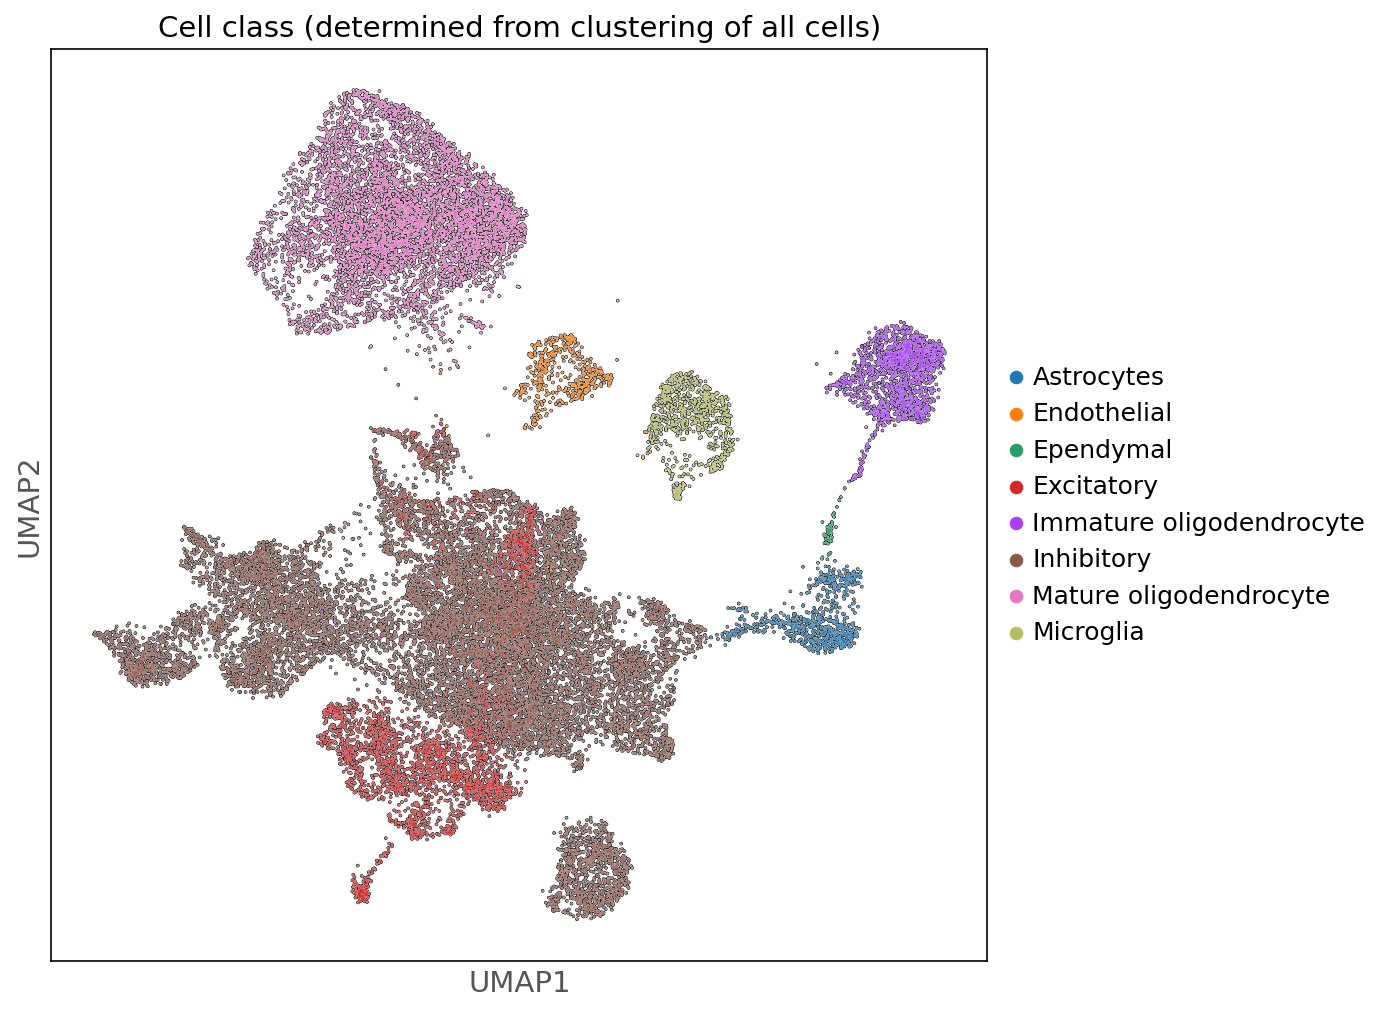

In [3]:
sc.pl.umap(adata_train, 
           color=['celltype'],
           add_outline=True,
           legend_fontsize=12,
           title='Cell class (determined from clustering of all cells)',
          save="_umap_reference")

In [5]:
celltype_colors = dict(zip(adata_train.obs["celltype"].cat.categories, adata_train.uns[f"celltype_colors"]))
celltype_colors

{'Astrocytes': '#1f77b4',
 'Endothelial': '#ff7f0e',
 'Ependymal': '#279e68',
 'Excitatory': '#d62728',
 'Immature oligodendrocyte': '#aa40fc',
 'Inhibitory': '#8c564b',
 'Mature oligodendrocyte': '#e377c2',
 'Microglia': '#b5bd61'}